# Automatic Number plate Detection using InceptionResNetV2

Automatic number plate detection is a technology that uses image processing and machine learning algorithms to automatically identify and extract vehicle license plate numbers from images.
This technology is often used in traffic management, surveillance, and law enforcement applications to accurately and efficiently identify and track vehicles. 

In [44]:
#Neccessary Imports

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Extracting annotated data from xml files and appending it to dict

path = glob('/content/drive/MyDrive/ANPR_extended/images_extended/*.xml')
labels_dict = dict(filepath=[],name=[],width=[],height=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_size=root.find('size')

    size_width=int(member_size.find('width').text)
    size_height=int(member_size.find('height').text)

    member_object = root.find('object')
    member_name = member_object.find('name').text
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    
    labels_dict['filepath'].append(filename)
    labels_dict['width'].append(size_width)
    labels_dict['height'].append(size_height)
    labels_dict['name'].append(member_name)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [4]:
#Converting labels_dict to dataframe and saving it to csv
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df

,filepath,name,width,height,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/ANPR_extended/images_ex...,num_plate,275,183,131,187,130,144
1,/content/drive/MyDrive/ANPR_extended/images_ex...,num_plate,1920,1080,976,1284,669,754
2,/content/drive/MyDrive/ANPR_extended/images_ex...,num_plate,932,699,73,260,381,462
3,/content/drive/MyDrive/ANPR_extended/images_ex...,num_plate,3644,2429,1326,1830,1464,1607
4,/content/drive/MyDrive/ANPR_extended/images_ex...,num_plate,3112,2340,1804,2493,1734,1882
...,...,...,...,...,...,...,...,...
602,/content/drive/MyDrive/ANPR_extended/images_ex...,number_plate,400,248,133,261,126,160
603,/content/drive/MyDrive/ANPR_extended/images_ex...,number_plate,400,300,98,297,102,191
604,/content/drive/MyDrive/ANPR_extended/images_ex...,number_plate,375,500,70,262,198,271
605,/content/drive/MyDrive/ANPR_extended/images_ex...,number_plate,600,400,278,407,182,263


In [5]:
# extract the respective image filename of the XML.
filename = df['filepath'][7]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/MyDrive/ANPR_extended/images_extended',filename_image)
    return filepath_image
getFilename(filename)

'/content/drive/MyDrive/ANPR_extended/images_extended/N7.jpeg'

In [45]:
#list of the image paths
image_path = list(df['filepath'].apply(getFilename))
image_path[:5]

['/content/drive/MyDrive/ANPR_extended/images_extended/N11.jpeg',
 '/content/drive/MyDrive/ANPR_extended/images_extended/N12.jpeg',
 '/content/drive/MyDrive/ANPR_extended/images_extended/N3.jpeg',
 '/content/drive/MyDrive/ANPR_extended/images_extended/N4.jpeg',
 '/content/drive/MyDrive/ANPR_extended/images_extended/N2.jpeg']


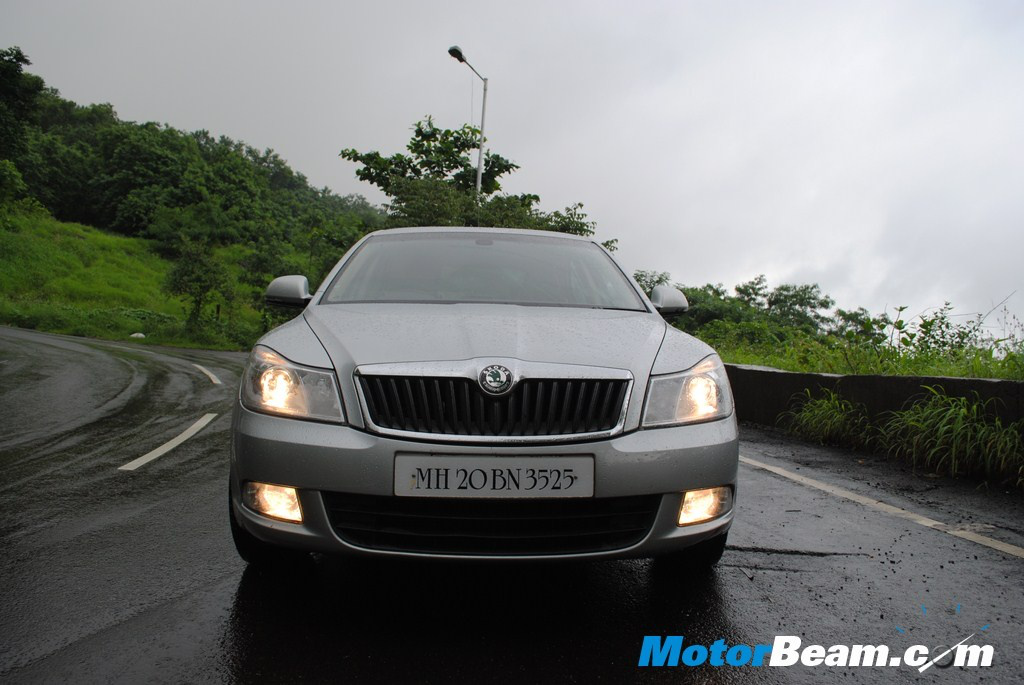

In [9]:
#Drawing Bounding box on any jpeg data
i=43
file_path = image_path[i] #path of our image any .jpeg
img = cv2.imread(file_path) #read the image

img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure  - jpeg with bounding box')
fig.add_shape(type='rect',x0=df.xmin[i], x1=df.xmax[i], y0=df.ymin[i], y1=df.ymax[i], xref='x', yref='y',line_color='cyan')

In [10]:
#Data Processing
#Converting df_labels_into array

df_labels = pd.get_dummies(df['name'])
labels=np.array(df_labels)
df_boxes=df.iloc[:,4:]
df_imagepath=df.iloc[:,:1].values.tolist()
df_labels

,num_plate,number_plate
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
602,0,1
603,0,1
604,0,1
605,0,1


In [11]:
#Targeting all our values in array selecting all columns
label = df_boxes.iloc[:,0:4].values

data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)

     # Normalization
    norm_load_image_arr = load_image_arr/255.0

    # Normalization to labels
    xmin,xmax,ymin,ymax = label[ind]

    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [12]:
# Converting input and output to array

data = np.array(data,dtype=np.float32)
output = np.array(output,dtype=np.float32)
data.shape,labels.shape,output.shape


((607, 224, 224, 3), (607, 2), (607, 4))

In [13]:
#Spliting data into train and test split
split=train_test_split(data,labels,output,df_imagepath,test_size=0.20,random_state=72)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]


In [14]:
#Spliting traning data into train and validation split
split2 = train_test_split(trainImages,trainLabels,trainBBoxes,trainPaths, test_size=0.125, random_state=1)
(trainImages, valImages) = split2[:2]
(trainLabels, valLabels) = split2[2:4]
(trainBBoxes, valBBoxes) = split2[4:6]
(trainPaths, valPaths) = split2[6:]

In [15]:
trainImages.shape,trainBBoxes.shape,testLabels.shape,testBBoxes.shape


((424, 224, 224, 3), (424, 4), (122, 2), (122, 4))

In [16]:
# construct a second dictionary, this one for our training targets

trainTargets = {

    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes

}

#valTragest to validate the data labels and boxes

valTargets={

    "class_label": valLabels,
    "bounding_box": valBBoxes

}


In [ ]:
#Model Building of InceptionResNetV2

inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
model1 = Dense(500,activation="relu")(headmodel)
model1 = Dense(250,activation="relu")(model1)
model1 = Dense(2,activation='sigmoid',name='class_label')(model1)

model2 = Dense(500,activation="relu")(headmodel)
model2 = Dense(250,activation="relu")(model2)
model2 = Dense(4,activation='sigmoid',name='bounding_box')(model2)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=(model1,model2))

219055592/219055592 [==============================] - 7s 0us/step


In [ ]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the

# class label and bounding box outputs will receive equal weight)

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0, 
}

In [ ]:
# Complie model
model.compile(loss=losses,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'],loss_weights=lossWeights)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tfb = TensorBoard('object_detection')
#Traning the model with trainImages and trainTragets with validation data
history = model.fit(trainImages,trainTargets,batch_size=10,epochs=100,validation_data=(valImages, valTargets),callbacks=[tfb])

Epoch 1/100
43/43 [==============================] - 53s 443ms/step - loss: 0.3606 - class_label_loss: 0.3256 - bounding_box_loss: 0.0350 - class_label_accuracy: 0.9552 - bounding_box_accuracy: 0.5307 - val_loss: 0.0615 - val_class_label_loss: 0.0026 - val_bounding_box_loss: 0.0589 - val_class_label_accuracy: 1.0000 - val_bounding_box_accuracy: 0.5082
Epoch 2/100
43/43 [==============================] - 11s 250ms/step - loss: 0.1078 - class_label_loss: 0.0860 - bounding_box_loss: 0.0217 - class_label_accuracy: 0.9788 - bounding_box_accuracy: 0.7099 - val_loss: 0.0393 - val_class_label_loss: 0.0020 - val_bounding_box_loss: 0.0373 - val_class_label_accuracy: 1.0000 - val_bounding_box_accuracy: 0.7541
Epoch 3/100
43/43 [==============================] - 10s 237ms/step - loss: 0.0318 - class_label_loss: 0.0189 - bounding_box_loss: 0.0130 - class_label_accuracy: 0.9906 - bounding_box_accuracy: 0.7524 - val_loss: 0.0252 - val_class_label_loss: 4.6117e-04 - val_bounding_box_loss: 0.0247 - val

In [ ]:
#Saving the h5 file in the system
model.save('/content/drive/MyDrive/ANPR_extended/object_detection_resnet.h5')

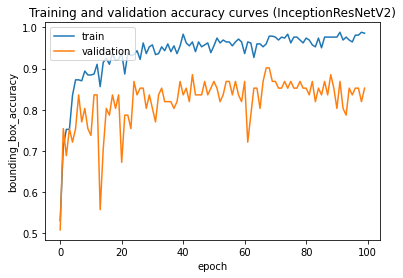

In [ ]:
#Accuracy Vs Epochs Graph
plt.plot(history.history['bounding_box_accuracy'])
plt.plot(history.history['val_bounding_box_accuracy'])
plt.title('Training and validation accuracy curves (InceptionResNetV2)')
plt.ylabel('bounding_box_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

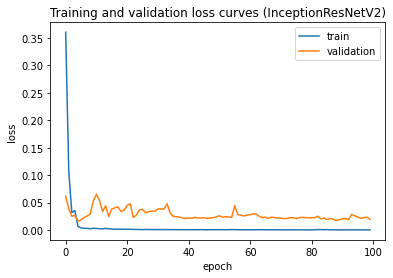

In [ ]:
#Loss vs epochs graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss curves (InceptionResNetV2)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evalating the results with testImages and testTargets
results = model.evaluate(testImages, testTargets,return_dict=True,batch_size=128)
print("bounding_box_loss:",results['bounding_box_loss']*100)
print("bounding_box_accuracy:",results['bounding_box_accuracy']*100)


1/1 [==============================] - 1s 652ms/step - loss: 0.1038 - class_label_loss: 0.0898 - bounding_box_loss: 0.0139 - class_label_accuracy: 0.9918 - bounding_box_accuracy: 0.8443
bounding_box_loss: 1.3937603682279587
bounding_box_accuracy: 84.42623019218445


In [17]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/ANPR_extended/object_detection_resnet.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


1/1 [==============================] - 1s 633ms/step


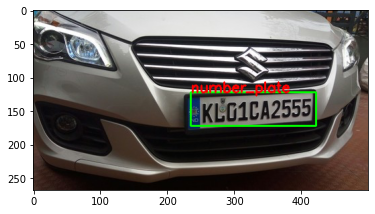

In [19]:
# Create pipeline for testing the data
path = '/content/drive/MyDrive/ANPR_extended/Test/Cars0.png'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    labels,coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords[0] * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin,xmax,ymin,ymax = coords
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    
    #predicting text according to the name in xml file 
    i = np.argmax(labels, axis=1)
    if(i[0]==1):
      text='number_plate'
    else:
      text='num_plate'
    
    cv2.rectangle(image,pt1,pt2,(0,255,0),2)
    cv2.putText(image, text , (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    return image, coords

image, cods = object_detection(path)
fig = plt.imshow(image)



1/1 [==============================] - 1s 602ms/step


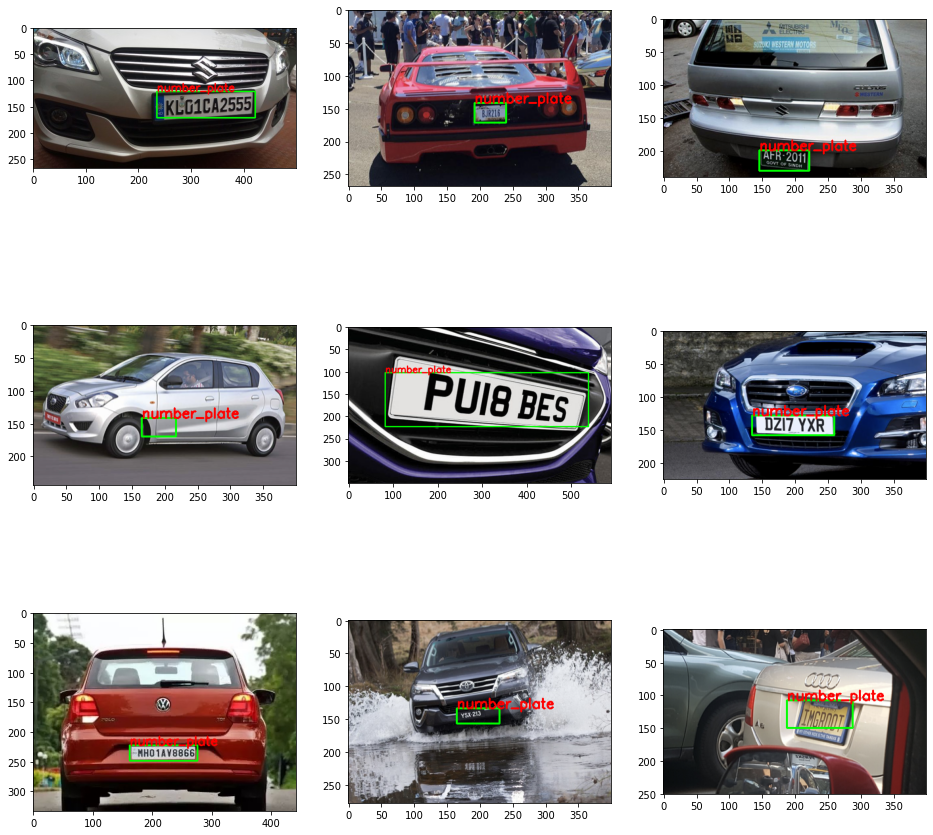

In [26]:
# Printing 9 random images from test folder for with InceptionmodelV2
import os
import random
import matplotlib.pyplot as plt
from PIL import Image # import the Image module from the Python Imaging Library (PIL)

# specify the folder containing the images
folder = r'/content/drive/MyDrive/ANPR_extended/Test'

# get a list of the files in the folder
file_list = os.listdir(folder)

# select a random sample of images
num_images = 9 # number of random images you want to select
random_images = random.sample(file_list, num_images)

# create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(figsize=(16,16),nrows=3, ncols=3)

# iterate through the list of random images and display each image in a subplot
for i, file in enumerate(random_images):
  file_path = os.path.join(folder, file)
  
  #Calling object_detection function for each picture
  image, cods = object_detection(file_path)
  ax[i // 3, i % 3].imshow(image)

# display the figure
plt.show()


#Number plate Detection using VGG16

In [ ]:
#Creating VGG16 model for the same dataset
VGG16_model = VGG16(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel_vgg = VGG16_model.output
headmodel_vgg = Flatten()(headmodel_vgg)
model3 = Dense(500,activation="relu")(headmodel_vgg)
model3 = Dense(250,activation="relu")(model3)
model3 = Dense(2,activation='sigmoid',name='class_label')(model3)

model4 = Dense(500,activation="relu")(headmodel_vgg)
model4 = Dense(250,activation="relu")(model4)
model4 = Dense(4,activation='sigmoid',name='bounding_box')(model4)


# ---------- model
model5 = Model(inputs=VGG16_model.input,outputs=(model3,model4))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
#Compiling the model 
model5.compile(loss=losses,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'],loss_weights=lossWeights)
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
#Training the Data with VGG16
history2 = model5.fit(trainImages,trainTargets,batch_size=10,epochs=100,validation_data=(valImages, valTargets))

Epoch 1/100
43/43 [==============================] - 15s 240ms/step - loss: 0.2023 - class_label_loss: 0.1766 - bounding_box_loss: 0.0257 - class_label_accuracy: 0.9552 - bounding_box_accuracy: 0.6061 - val_loss: 0.0375 - val_class_label_loss: 0.0166 - val_bounding_box_loss: 0.0209 - val_class_label_accuracy: 1.0000 - val_bounding_box_accuracy: 0.6230
Epoch 2/100
43/43 [==============================] - 7s 172ms/step - loss: 0.1295 - class_label_loss: 0.1061 - bounding_box_loss: 0.0234 - class_label_accuracy: 0.9788 - bounding_box_accuracy: 0.6580 - val_loss: 0.0319 - val_class_label_loss: 0.0108 - val_bounding_box_loss: 0.0211 - val_class_label_accuracy: 1.0000 - val_bounding_box_accuracy: 0.5246
Epoch 3/100
43/43 [==============================] - 7s 173ms/step - loss: 0.1252 - class_label_loss: 0.1037 - bounding_box_loss: 0.0215 - class_label_accuracy: 0.9788 - bounding_box_accuracy: 0.6816 - val_loss: 0.0322 - val_class_label_loss: 0.0118 - val_bounding_box_loss: 0.0205 - val_class

In [ ]:
#Saving VGG16 model onto the system
model5.save('/content/drive/MyDrive/ANPR_extended/object_detection_vgg16.h5')

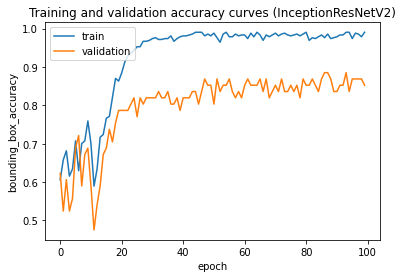

In [ ]:
#Accuray vs Epocs for the VGG16 model
plt.plot(history2.history['bounding_box_accuracy'])
plt.plot(history2.history['val_bounding_box_accuracy'])
plt.title('Training and validation accuracy curves (VGG16)')
plt.ylabel('bounding_box_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

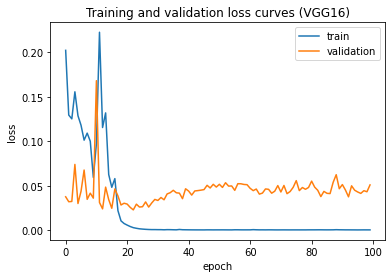

In [ ]:
#Loss vs Epochs for VGG16 model
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training and validation loss curves (VGG16)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Evaluating the model with TestImages and testTargets
results2 = model5.evaluate(testImages, testTargets,return_dict=True,batch_size=128)
print("bounding_box_loss:",results2['bounding_box_loss']*100)
print("bounding_box_accuracy:",results2['bounding_box_accuracy']*100)


1/1 [==============================] - 11s 11s/step - loss: 0.0911 - class_label_loss: 0.0803 - bounding_box_loss: 0.0109 - class_label_accuracy: 0.9836 - bounding_box_accuracy: 0.7951
bounding_box_loss: 1.08543885871768
bounding_box_accuracy: 79.50819730758667


In [28]:
# Load model
model5 = tf.keras.models.load_model('/content/drive/MyDrive/ANPR_extended/object_detection_vgg16.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


1/1 [==============================] - 0s 394ms/step


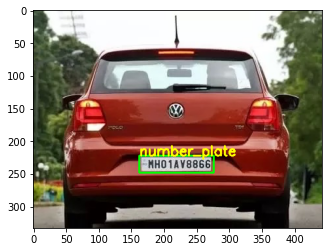

In [43]:
# Create pipeline for testing the data
path = r'/content/drive/MyDrive/ANPR_extended/Test/Cars9.png'

def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    labels,coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords[0] * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin,xmax,ymin,ymax = coords
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    
    #predicting text according to the name in xml file 
    i = np.argmax(labels, axis=1)
    if(i[0]==1):
      text='number_plate'
    else:
      text='num_plate'
    
    cv2.rectangle(image,pt1,pt2,(0,255,0),2)
    cv2.putText(image, text , (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 255, 0), 2)
    return image, coords

image, cods = object_detection(path)
fig = plt.imshow(image)



1/1 [==============================] - 0s 369ms/step


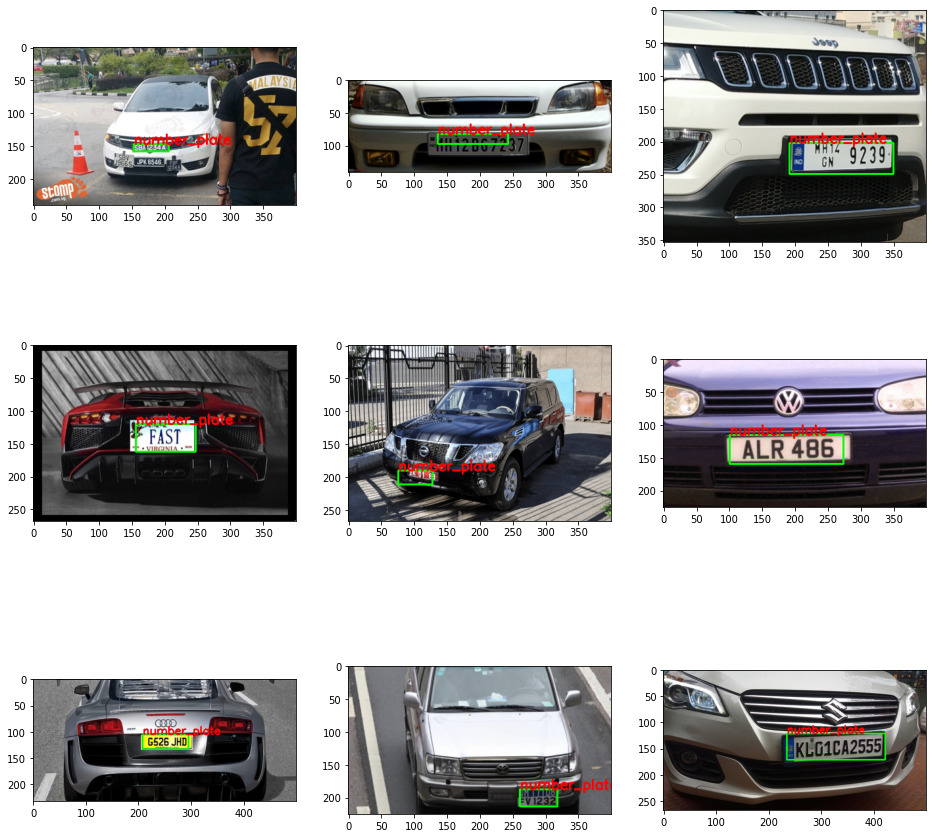

In [40]:
#Printing 9 random images from Test folder for prediction
import os
import random
import matplotlib.pyplot as plt
from PIL import Image # import the Image module from the Python Imaging Library (PIL)

# specify the folder containing the images
folder = r'/content/drive/MyDrive/ANPR_extended/Test'

# get a list of the files in the folder
file_list = os.listdir(folder)

# select a random sample of images
num_images = 9 # number of random images you want to select
random_images = random.sample(file_list, num_images)

# create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(figsize=(16,16),nrows=3, ncols=3)

# iterate through the list of random images and display each image in a subplot
for i, file in enumerate(random_images):
  file_path = os.path.join(folder, file)
  
  #Calling object_detection function for each picture
  image, cods = object_detection(file_path)
  ax[i // 3, i % 3].imshow(image)

# display the figure
plt.show()


# Comparsion between InceptionResNetV2 and VGG16 on Automatic Number Plate detection

**Accuracy scores of InceptionResNetV2**

1.   Bounding Box Loss: 1.39%
2.   Bounding Box Accuracy: 84.42623019218445%
3.   Class label accuracy: 99.18 %
4.   Class Label Loss: 8.9%



**Accuracy scores of VGG16**


1.   Bounding Box Loss: 1.09%
2.   Bounding Box Accuracy: 79.50819730758667%
3.   Class label accuracy: 98.36 %
4.   Class Label Loss: 8.03%


Based on the accuracy scores that above, it looks like Inception-ResNet-v2 outperforms VGG16 in most of the metrics. In particular, Inception-ResNet-v2 has a higher bounding box accuracy and class label accuracy, and a lower bounding box loss and class label loss. This suggests that Inception-ResNet-v2 is better at accurately identifying and classifying objects in images.

* Inception-ResNet-v2 and VGG16 are both convolutional neural network architectures that have been trained on the ImageNet dataset, which is a large dataset of images with labels. However, there are some key differences between the two architectures.

* One major difference is the number of parameters in the models. VGG16 has about 138 million parameters, while Inception-ResNet-v2 has about 55 million parameters. This means that VGG16 is significantly larger and more complex than Inception-ResNet-v2.

* Another difference is the number of layers in the models. VGG16 is a relatively shallow network with 16 layers, while Inception-ResNet-v2 is a much deeper network with over 100 layers. This means that Inception-ResNet-v2 has the potential to learn more complex features, but also that it is more computationally expensive to train and use.

* In terms of performance, VGG16 and Inception-ResNet-v2 are both highly accurate on the ImageNet dataset, with Inception-ResNet-v2 achieving slightly higher accuracy. 